In [1]:
# followed this tutorial and applied it to my project https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

from tokenizers.pre_tokenizers import Whitespace

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
destination_folder = 'C:/Users/Manu/Documents/JupyterNotebook_notebooks/Reddit_political_affiliation/model_checkpoints'

# some more preprocessing

# pretrained model that was trained on lowercase text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # this pretokenizer separates text and punctuation
# pre_tokenizer = Whitespace()

# tokenizer.pre_tokenizer = pre_tokenizer

#params
MAX_SEQ_LEN = 256

# tokens used for padding or unknown tokens (token that are not in the vocab)
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)

# must match csv file structure. Only text is used in the model
fields=[('body', text_field), ('subreddit', label_field) ]

# Tabular dataset

train, valid, test = TabularDataset.splits(path='./',train='train.csv', validation='valid.csv', test='test.csv',
                                          format='CSV', fields=fields, skip_header=True)


#iterators 



train_iter = BucketIterator(train, batch_size=8, sort_key=lambda x:len(x.Body), device=device,
                             train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=8, sort_key=lambda x:len(x.Body), device=device,
                            train=True, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=8, device=device, train=False, shuffle=False, sort=False)





Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


KeyboardInterrupt: 

In [4]:


# bulding the model

class BERT(nn.Module): # nn.module is base class for all neural network modules
    def __init__(self):
        super(BERT,self).__init__()
        
        
        # BertForSequenceClassification implementation:
        # https://github.com/huggingface/transformers/blob/9aeacb58bab321bc21c24bbdf7a24efdccb1d426/src/transformers/modeling_bert.py#L1353-L1360 
        # loss function is the cross enthropy loss function
        self.encoder = BertForSequenceClassification.from_pretrained('bert-base-uncased')
        
    def forward(self, text, label):
        loss, test_feats = self.encoder(text,labels=label)[:2]
        return loss, test_feats


In [16]:

def save_checkpoint(save_path, model, valid_loss):
    if save_path==None:
        return
    
    # state_dict is a python dictionary object that maps each layer to its parameter tensor(?)
    state_dict = {'model_state_dict': model.state_dict(), 'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    
def load_checkpoint(load_path, model):
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location='cpu')
    print(f'Model loaded from {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list, 'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    
def load_metrics(load_path):
    if load_path == None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [6]:

# train

def train(model, optimizer, criterion= nn.BCELoss(), train_loader=train_iter, valid_loader=valid_iter,
         num_epochs=5, eval_every=len(train_iter)//2, file_path=destination_folder, best_valid_loss=float('Inf')):
    
    # initializing running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    
    # training loop
    
    model.train()
    for epoch in range(num_epochs):
        for (body, score, subreddits, post, titletext), _ in train_loader:
            subreddits = subreddits.type(torch.LongTensor)
            # loading on gpu \
            subreddits = subreddits.to(device)
            titletext = titletext.type(torch.LongTensor)
            titletext = titletext.to(device)
            output = model(titletext, subreddits)
            loss, _ = output
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # update running vluaes
            running_loss += loss.item()
            global_step += 1
            
            #eval step
            if global_step % eval_every ==0:
                model.eval()
                with torch.no_grad():
                    
                    # val loop
                    
                    for(body, score, subreddits, post, titletext), _ in valid_loader:
                        subreddits = subreddits.type(torch.LongTensor)
                        # loading on gpu \
                        subreddits = subreddits.to(device)
                        titletext = titletext.type(torch.LongTensor)
                        titletext = titletext.to(device)
                        output = model(titletext, subreddits)
                        loss, _ = output

                        valid_running_loss += loss.item()
                
                #eval
                average_train_loss = running_loss/eval_every
                average_valid_loss = valid_running_loss/ len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
                
                # resetting values 
                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()
                
                # progress feedback
                print(f'Epoch [{epoch+1}/{num_epochs}], step [{global_step}/{num_epochs*len(train_loader)}], \
                      Train Loss: {average_train_loss}, valid_loss: {average_valid_loss}\n')
                      
                #checkpoints
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
                      
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
                                 

In [7]:
%%time
# training

model = BERT().to(device)
#using adam optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], step [431/4310],                       Train Loss: 0.6653258357966306, valid_loss: 0.6596051142022417

Epoch [1/5], step [862/4310],                       Train Loss: 0.5198132904665652, valid_loss: 0.7231737743761089

Epoch [2/5], step [1293/4310],                       Train Loss: 0.4707328142498873, valid_loss: 0.3997073036996094

Epoch [2/5], step [1724/4310],                       Train Loss: 0.26674295295453404, valid_loss: 0.39657139871772884

Epoch [3/5], step [2155/4310],                       Train Loss: 0.21933730320222763, valid_loss: 0.3279483364794303

Epoch [3/5], step [2586/4310],                       Train Loss: 0.11576143230620572, valid_loss: 0.428819715601669

Epoch [4/5], step [3017/4310],                       Train Loss: 0.11199354737232117, valid_loss: 0.3346225337641364

Epoch [4/5], step [3448/4310],                       Train Loss: 0.06061439123193749, valid_loss: 0.4995205812747716

Epoch [5/5], step [3879/4310],                       Train Lo

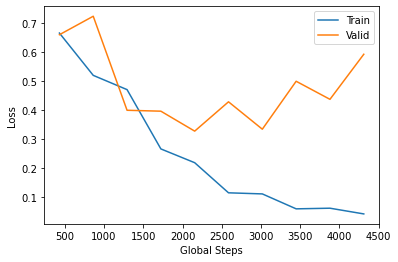

In [11]:
# plotting

train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')

plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from C:/Users/Manu/Documents/JupyterNotebook_notebooks/Reddit_political_affiliation/model_checkpoints/model.pt
classification Report:
              precision    recall  f1-score   support

           1     0.8637    0.8978    0.8804       734
           0     0.8951    0.8602    0.8773       744

    accuracy                         0.8789      1478
   macro avg     0.8794    0.8790    0.8789      1478
weighted avg     0.8795    0.8789    0.8789      1478

Wall time: 27.4 s


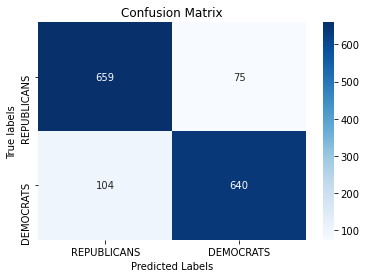

In [23]:
%%time
#evaluating test set

def evaluate(model, test_loader):
    y_pred = []
    y_gt = []
    
    model.eval()
    with torch.no_grad():
        for(body, score, subreddits, post, titletext), _ in test_loader:
            subreddits = subreddits.type(torch.LongTensor)
            # loading on gpu \
            subreddits = subreddits.to(device)
            titletext = titletext.type(torch.LongTensor)
            titletext = titletext.to(device)
            output = model(titletext, subreddits)
            
            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_gt.extend(subreddits.tolist())
    
    print(f'classification Report:\n{classification_report(y_gt, y_pred, labels=[1,0], digits=4)}')
    
    cm = confusion_matrix(y_gt, y_pred, labels=[1,0])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='d')
    
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['REPUBLICANS', 'DEMOCRATS'])
    ax.yaxis.set_ticklabels(['REPUBLICANS', 'DEMOCRATS'])
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)
            